# Day 56 · 时序数据的检验

在学习时间序列预测模型之前，我们需要掌握时序数据的检验方法。本节将系统介绍假设检验的基本概念，以及白噪声检验、平稳性检验和季节性检验的原理与实现。

## 环境准备

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # 绘制自相关/偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box检验
from statsmodels.tsa.stattools import adfuller  # ADF检验
from statsmodels.tsa.seasonal import seasonal_decompose  # 序列分解
import warnings
warnings.filterwarnings("ignore")

# 中文显示设置
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

---
## 一、假设检验基础

### 1.1 原假设与备择假设

**核心思想**：在统计学中，我们不能直接证明一件事是什么，而是先假设它不是，然后用证据去推翻这个假设。

**类比理解**：
- 在法庭上，嫌疑人在被定罪前被假设为**无罪**（原假设 H0）
- 检察官需要提供证据证明嫌疑人**有罪**（备择假设 H1）

**原假设的特点**：
- 通常是一个清晰、单一的状态
- 用数学语言表示为等式形式（如：罪 = 0）
- 是我们想要挑战或推翻的假设

**备择假设的特点**：
- 是原假设的对立面
- 通常是我们期待证明的、有价值的发现

### 1.2 统计量与P值

**统计量**：
- 反映样本数据偏离原假设的程度
- 统计量的值越大，说明两组数据的差异越明显

**P值（p-value）**：
- 证据强度的量化指标
- 回答的核心问题：如果原假设是真的，我们现在看到的证据有多大可能性纯属巧合？
- P值越小，说明证据越与原假设格格不入

**显著性水平**：
- 通常设定为 0.05（即5%）
- **p-value < 0.05**：拒绝原假设（reject H0）
- **p-value >= 0.05**：无法拒绝原假设（fail to reject H0）

**置信区间**：
- 落在置信区间内 -> 无法拒绝原假设
- 落在置信区间外 -> 拒绝原假设

**记忆口诀**：p越小，落在置信区间外，越拒绝原假设。

---
## 二、白噪声检验

### 2.1 白噪声的定义

**为什么要检验白噪声？**
- 时序预测的前提是数据本身具有可预测性
- 完全随机的序列（白噪声）是不可预测的
- 白噪声的未来值与过去值没有任何相关性

**白噪声的三大特征**：
1. **均值为0**
2. **方差恒定**
3. **自相关性为0**（过去的值对未来的值没有影响）

生成的前10个数据点:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]


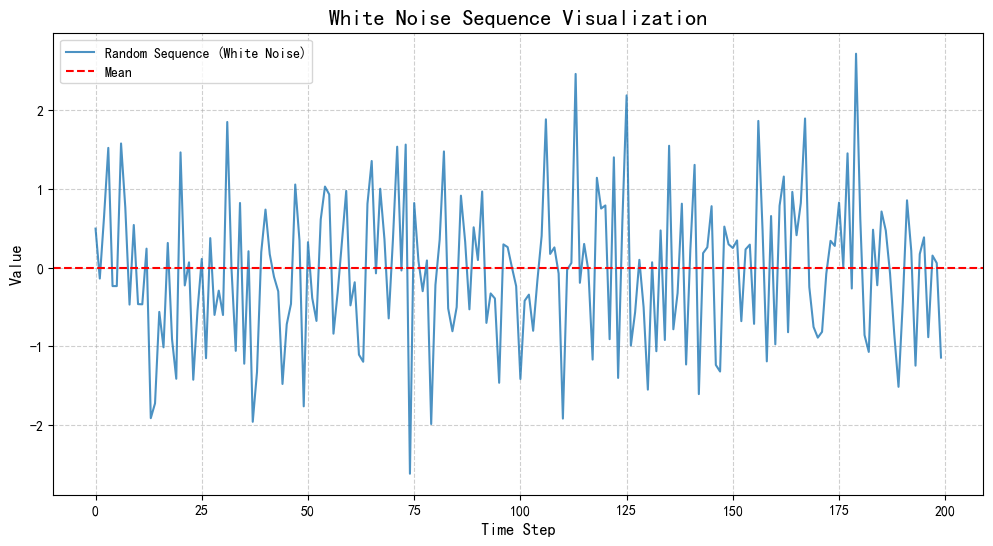

In [2]:
# 生成白噪声序列
np.random.seed(42)  # 设置随机种子，保证结果可复现
num_points = 200  # 序列长度

# 从标准正态分布（均值为0，方差为1）中抽取随机样本
random_sequence = np.random.randn(num_points)

print("生成的前10个数据点:")
print(random_sequence[:10])

# 可视化白噪声序列
plt.figure(figsize=(12, 6))
plt.plot(random_sequence, label='Random Sequence (White Noise)', alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--', label='Mean')
plt.title('White Noise Sequence Visualization', fontsize=16)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

### 2.2 ACF检验（自相关函数检验）

**ACF（Autocorrelation Function）**：
- 衡量序列与其滞后版本之间的相关性
- 对于白噪声，只有lag=0时相关性为1，其他滞后的相关性都应在置信区间内

**ACF图的解读**：
- 蓝色阴影区域：95%置信区间
- 如果所有滞后项都在置信区间内，说明序列可能是白噪声

--- Start White Noise Test ---
1. Mean of sequence: -0.0408
   (Conclusion: Mean is very close to 0, condition satisfied.)

2. Variance of sequence: 0.8624
   (Conclusion: Variance is close to 1, condition satisfied.)

3. Test autocorrelation (using ACF plot):
   - ACF plot shows correlation between sequence and its lagged values.
   - For white noise, only lag=0 has correlation=1, others should be within confidence interval.


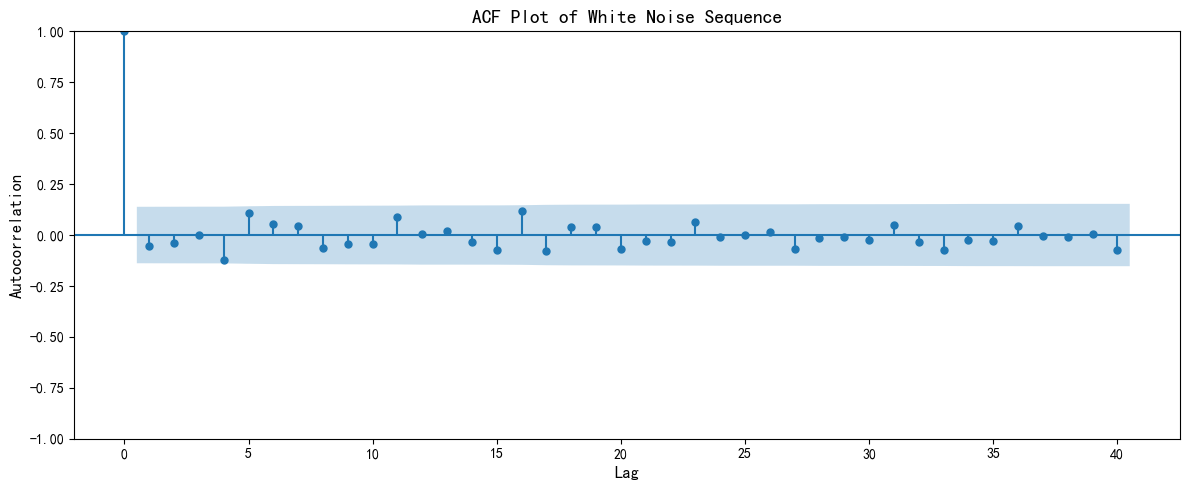

In [3]:
# 检验白噪声属性
print("--- Start White Noise Test ---")
print(f"1. Mean of sequence: {random_sequence.mean():.4f}")
print("   (Conclusion: Mean is very close to 0, condition satisfied.)\n")

print(f"2. Variance of sequence: {random_sequence.var():.4f}")
print("   (Conclusion: Variance is close to 1, condition satisfied.)\n")

print("3. Test autocorrelation (using ACF plot):")
print("   - ACF plot shows correlation between sequence and its lagged values.")
print("   - For white noise, only lag=0 has correlation=1, others should be within confidence interval.")

# 绘制ACF图
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(random_sequence, lags=40, ax=ax, alpha=0.05)  # alpha=0.05表示95%置信区间
ax.set_title('ACF Plot of White Noise Sequence', fontsize=14)
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
plt.tight_layout()
plt.show()

### 2.3 PACF检验（偏自相关函数检验）

**PACF（Partial Autocorrelation Function）**：
- 衡量序列与其第k阶滞后之间的**直接相关性**
- 直观理解：把中间滞后项（lag=1...k-1）的影响剔除后，看 y(t) 与 y(t-k) 是否仍有线性关系

**ACF vs PACF**：
- ACF：总体相关性（包含间接影响）
- PACF：直接相关性（剔除间接影响）

**对白噪声的判断**：
- 如果各滞后阶（lag>0）都落在置信区间内，说明没有显著相关性，序列可能是白噪声

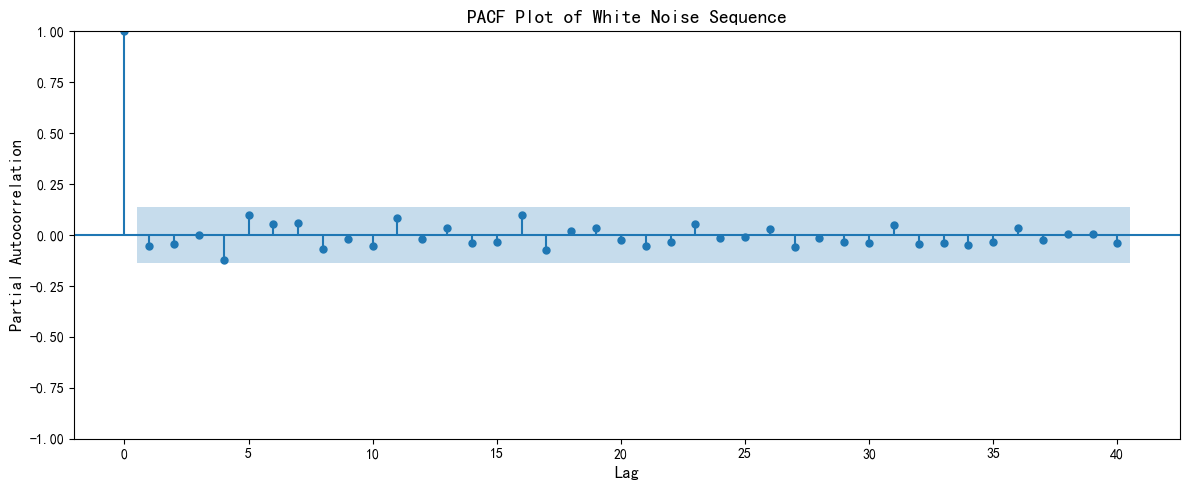

In [4]:
# 绘制PACF图
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(random_sequence, lags=40, ax=ax, alpha=0.05)  # alpha=0.05表示95%置信区间
ax.set_title('PACF Plot of White Noise Sequence', fontsize=14)
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Partial Autocorrelation', fontsize=12)
plt.tight_layout()
plt.show()

### 2.4 Ljung-Box检验

**检验目的**：综合检验多个滞后阶的自相关性是否显著

**假设设定**：
- **原假设 (H0)**：序列是白噪声（各阶自相关系数都为0）
- **备择假设 (H1)**：序列不是白噪声

**判断标准**：
- p-value >= 0.05 -> 无法拒绝原假设，认为序列是白噪声
- p-value < 0.05 -> 拒绝原假设，认为序列不是白噪声

In [5]:
# Ljung-Box检验
print("=" * 50)
print("Ljung-Box Test")
print("=" * 50)
print("   - H0: Sequence is white noise.")
print("   - Criterion: If p-value >= 0.05, cannot reject H0, sequence is white noise.")

# 执行Ljung-Box检验，检查前10、20、30个滞后项
ljung_box_result = acorr_ljungbox(random_sequence, lags=[10, 20, 30], return_df=True)

print("\nLjung-Box Test Results:")
print(ljung_box_result)

# 结论解释
print("\n--- Test Conclusion ---")
last_p_value = ljung_box_result.iloc[-1]['lb_pvalue']  # 获取最后一个滞后阶的p值

if last_p_value < 0.05:
    print(f"At lag 30, p-value ({last_p_value:.4f}) < 0.05.")
    print("Conclusion: Reject H0, sequence is NOT white noise.")
else:
    print(f"At lag 30, p-value ({last_p_value:.4f}) >= 0.05.")
    print("Conclusion: Cannot reject H0, sequence IS white noise.")

Ljung-Box Test
   - H0: Sequence is white noise.
   - Criterion: If p-value >= 0.05, cannot reject H0, sequence is white noise.

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   8.849179   0.546474
20  18.264036   0.570020
30  21.000649   0.887868

--- Test Conclusion ---
At lag 30, p-value (0.8879) >= 0.05.
Conclusion: Cannot reject H0, sequence IS white noise.


**结果解读**：
- `lb_stat`：Ljung-Box统计量的值（证据强度）
- `lb_pvalue`：p值（判断依据）
- 行索引 10, 20, 30：综合考虑了前10个、前20个、前30个滞后项的自相关性

所有的p值都远大于0.05，代表无法拒绝原假设，序列是白噪声。

---
## 三、平稳性检验

### 3.1 平稳性的定义

**为什么要检验平稳性？**
- 如果一个序列不是白噪声，说明它包含可预测的规律
- 但在寻找规律前，我们需要确认这个规律本身是否稳定
- 平稳性是很多经典模型（如ARIMA）能够有效工作的前提

**平稳序列的特征**：
- 统计特性（均值、方差）不随时间变化
- 序列中的规律是可重复、可学习的

**非平稳序列的例子**：
- 持续上涨的股票价格（均值在变）
- 夏天销量高、冬天销量低的冰淇淋销售数据（存在季节性）

**注意**：白噪声虽然看起来很乱，但实际上是平稳的（均值和方差恒定）。

### 3.2 ADF检验（单位根检验）

**检验目的**：判断时间序列是否平稳

**假设设定**：
- **原假设 (H0)**：序列是非平稳的（存在单位根）
- **备择假设 (H1)**：序列是平稳的

**判断规则**：
- p-value < 0.05 -> 拒绝原假设，认为序列是**平稳的**
- p-value >= 0.05 -> 无法拒绝原假设，认为序列是**非平稳的**

**辅助判断**：
- 如果ADF统计量 < 临界值（如5%临界值），也表明序列是平稳的

In [6]:
# ADF平稳性检验
print("Starting ADF Stationarity Test...")

# 执行ADF检验
adf_result = adfuller(random_sequence)

# 提取并展示主要结果
adf_statistic = adf_result[0]  # ADF统计量
p_value = adf_result[1]  # p值
critical_values = adf_result[4]  # 临界值

print(f"ADF Statistic: {adf_statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f'    {key}: {value:.4f}')

print("\n--- Test Conclusion ---")
# 根据p值进行判断
if p_value < 0.05:
    print(f"p-value ({p_value:.4f}) < 0.05, strongly reject H0.")
    print("Conclusion: Sequence is Stationary.")
else:
    print(f"p-value ({p_value:.4f}) >= 0.05, cannot reject H0.")
    print("Conclusion: Sequence is Non-stationary.")

# 通过比较ADF统计量和临界值来判断
if adf_statistic < critical_values['5%']:
    print("\nAdditional: ADF statistic < 5% critical value, also indicates stationarity.")

Starting ADF Stationarity Test...
ADF Statistic: -14.7442
p-value: 0.0000
Critical Values:
    1%: -3.4636
    5%: -2.8762
    10%: -2.5746

--- Test Conclusion ---
p-value (0.0000) < 0.05, strongly reject H0.
Conclusion: Sequence is Stationary.

Additional: ADF statistic < 5% critical value, also indicates stationarity.


---
## 四、季节性检验

### 4.1 季节性的定义

**什么是季节性？**
- 时间序列中以固定、已知的频率重复出现的模式或周期性波动
- 可以理解为数据的心跳或呼吸，有规律、可预测

**季节性的例子**：
- **冰淇淋销量**：每年夏天达到高峰，冬天降到谷底（周期：12个月）
- **工作日用电量**：每天早上8点开始攀升，晚上回落（周期：24小时）
- **零售业销售额**：每年第四季度（节假日）最高（周期：4个季度）

**季节性 vs 周期性**：
- **季节性**：频率固定且已知（年、季度、月、周、日）
- **周期性**：模式长度可变且不固定（如商业周期）

**为什么要检验季节性？**
- 季节性是数据中最强大、最明显的预测信号之一
- 如果模型不能识别和利用季节性，预测结果将出现系统性的周期性误差

### 4.2 通过ACF图检测季节性

**ACF图的季节性特征**：
- 如果序列存在季节性，ACF图会在代表季节性周期的滞后点上出现显著的尖峰
- 例如：月度数据（年度季节性，周期为12），在 lag=12, 24, 36, ... 的位置会看到很高的相关性

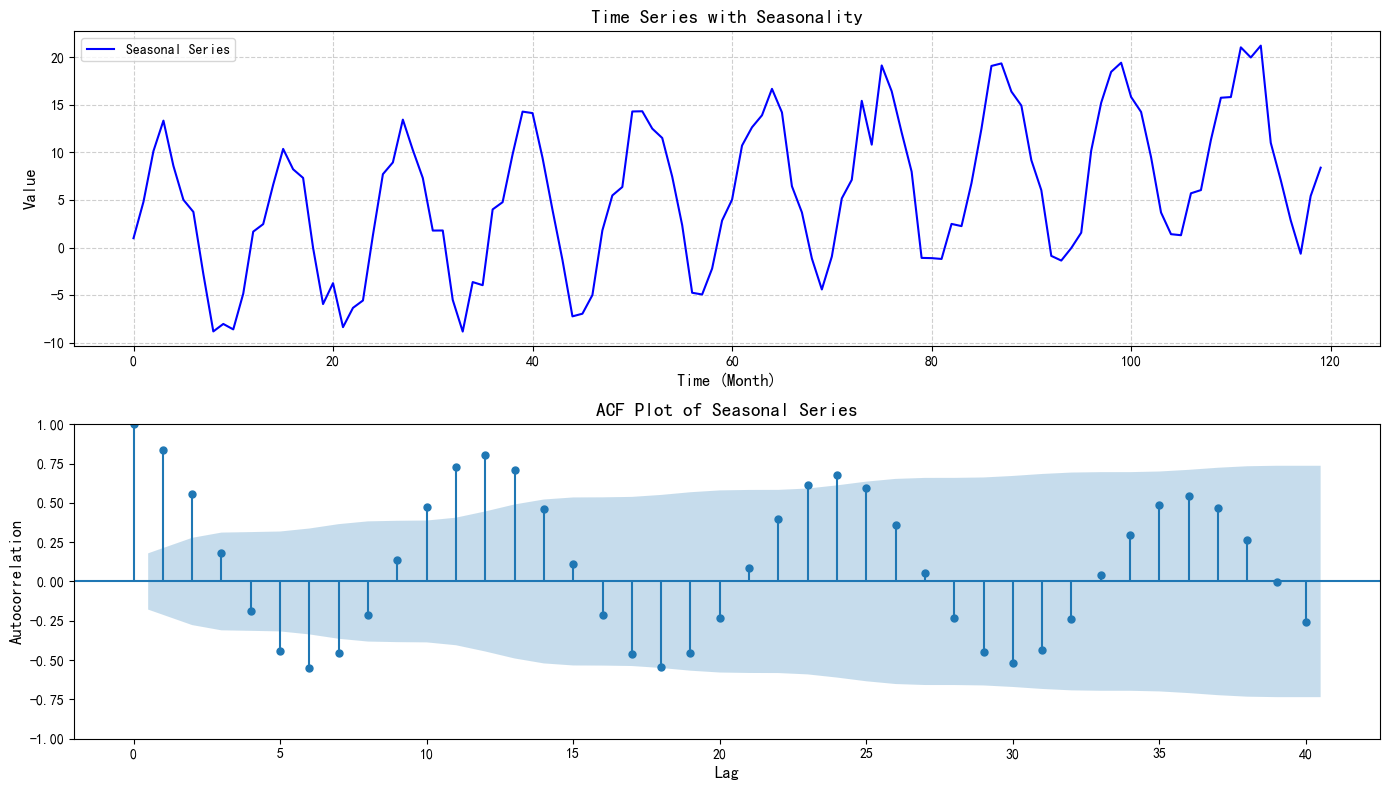


--- Seasonality Analysis ---
Observe the ACF plot: significant spikes at lag=12, 24, 36...
This indicates the series has seasonality with period=12 (annual seasonality).


In [7]:
# 生成具有季节性的序列
np.random.seed(42)
n = 120  # 10年的月度数据
time = np.arange(n)

# 创建季节性成分（周期为12个月）
seasonal_component = 10 * np.sin(2 * np.pi * time / 12)

# 创建趋势成分
trend_component = 0.1 * time

# 创建随机噪声
noise = np.random.randn(n) * 2

# 合成序列
seasonal_series = seasonal_component + trend_component + noise

# 可视化
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 绘制时序图
axes[0].plot(seasonal_series, label='Seasonal Series', color='blue')
axes[0].set_title('Time Series with Seasonality', fontsize=14)
axes[0].set_xlabel('Time (Month)', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# 绘制ACF图
plot_acf(seasonal_series, lags=40, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF Plot of Seasonal Series', fontsize=14)
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Autocorrelation', fontsize=12)

plt.tight_layout()
plt.show()

print("\n--- Seasonality Analysis ---")
print("Observe the ACF plot: significant spikes at lag=12, 24, 36...")
print("This indicates the series has seasonality with period=12 (annual seasonality).")

### 4.3 通过序列分解检测季节性

**思路**：把序列拆分为 趋势（Trend） + 季节性（Seasonal） + 残差（Residual）

**解读要点**：
- Seasonal部分是否呈现稳定重复的周期
- Resid残差不一定是白噪声：如果残差仍有结构，说明还存在可学习的信息（可进一步对残差画ACF或做Ljung-Box检验）

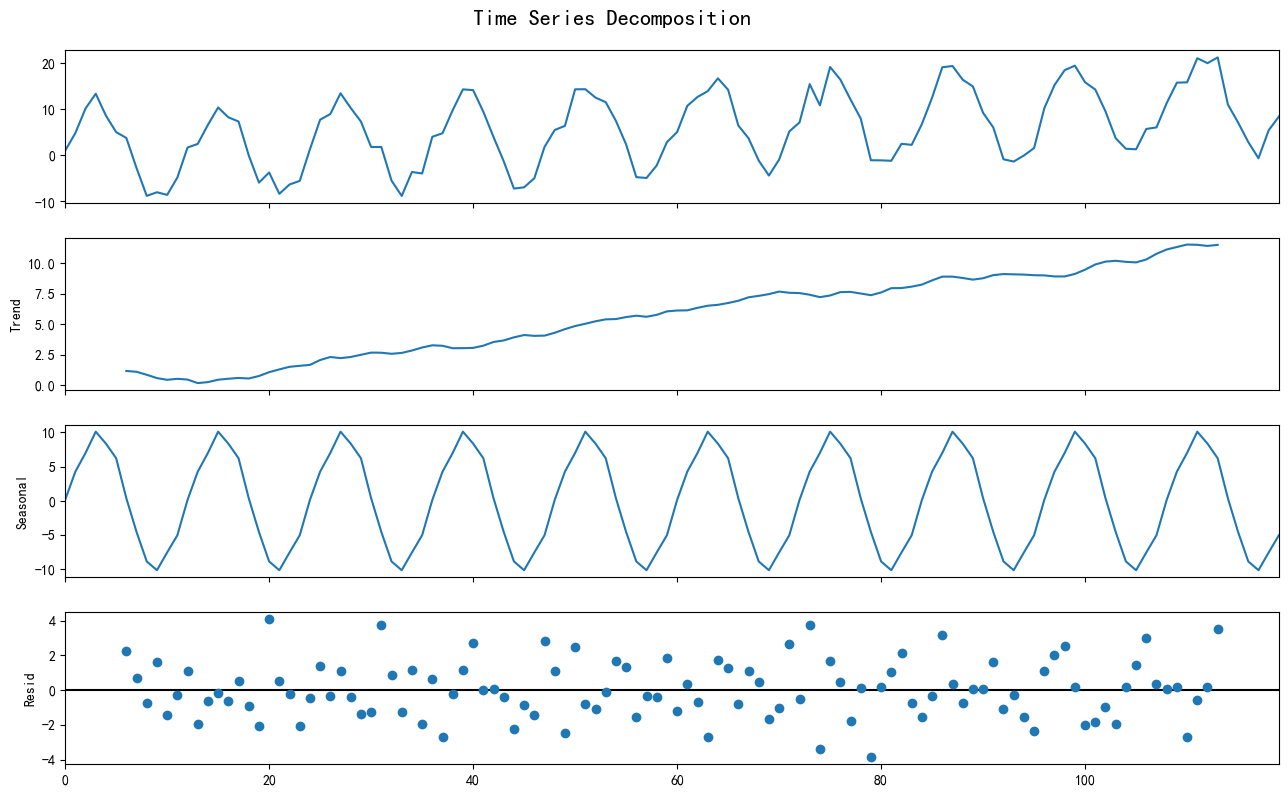

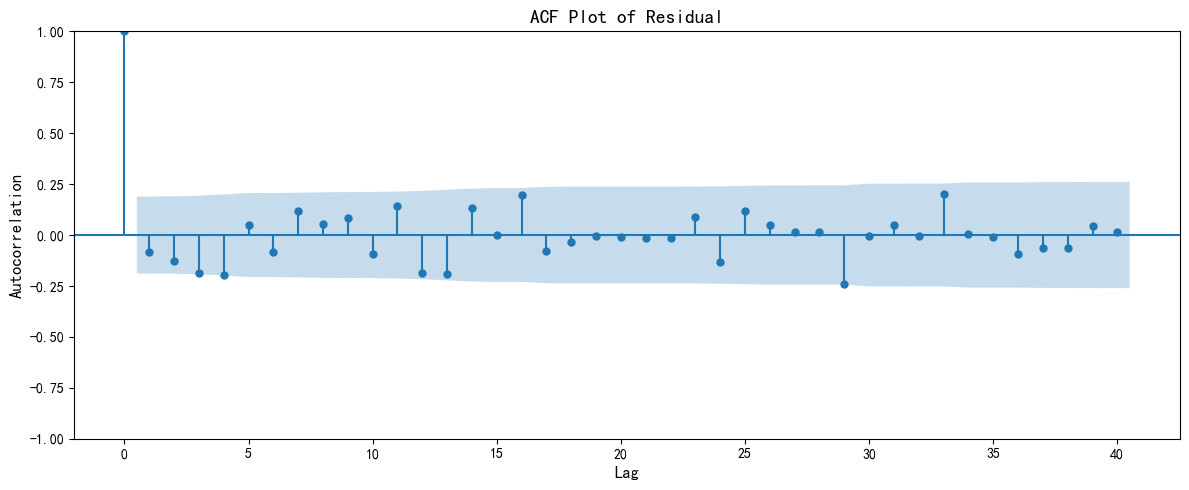

In [8]:
# 序列分解（加法模型）
series = pd.Series(seasonal_series)
decomposition = seasonal_decompose(series, model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Time Series Decomposition', y=1.02, fontsize=16)
plt.show()

# 可选：对残差画ACF，查看是否接近白噪声
resid = decomposition.resid.dropna()
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(resid, lags=40, ax=ax, alpha=0.05)
ax.set_title('ACF Plot of Residual', fontsize=14)
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
plt.tight_layout()
plt.show()

---
## 五、总结

### 5.1 检验流程

在进行时间序列分析前，建议按以下顺序进行检验：

1. **白噪声检验**：确认数据是否具有可预测性
   - 使用ACF/PACF图和Ljung-Box检验
   - 如果是白噪声，则无法进行有效预测

2. **平稳性检验**：确认数据的统计特性是否稳定
   - 使用ADF检验
   - 如果非平稳，需要进行差分等处理

3. **季节性检验**：识别数据中的周期性模式
   - 观察ACF图中的周期性尖峰，或使用序列分解
   - 如果存在季节性，需要在模型中考虑

### 5.2 检验方法速查表

| 检验类型 | 方法 | 原假设 | 判断标准 |
|---------|------|--------|----------|
| 白噪声检验 | ACF/PACF图 | - | 观察滞后项是否落在置信区间 |
| 白噪声检验 | Ljung-Box | 序列是白噪声 | p >= 0.05 无法拒绝 |
| 平稳性检验 | ADF | 序列非平稳 | p < 0.05 拒绝（平稳） |
| 季节性检验 | ACF图 | - | 观察周期性尖峰 |
| 季节性检验 | 序列分解 | - | 观察Seasonal是否周期重复 |